# Figure 2 & S2 - Inferring expansions

This notebook reproduces many of the panels in Figure 2 and S2 of Yang\*, Jones\*, et al, _bioRxiv_ 2021. Specifically, this notebook will call expansions and reproduce panels summarizing these expansions.

In [47]:
import os

import ete3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm

import clonal_expansions

from cassiopeia.solver import solver_utilities

In [ ]:
data_directory = "/path/to/KPTracer-Data/"

In [22]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

sigscores = pd.read_csv(f"{data_directory}/expression/signature_scores_sgNT.tsv", sep='\t', index_col = 0,
                        usecols = ['REACTOME_CELL_CYCLE', 'FitnessSignature'])
tumor_clone_statistics = pd.read_csv(f"{data_directory}/tumor_statistics.tsv", sep='\t', index_col = 0)
trcr_master = pd.read_csv(f"{data_directory}/trcr_master.txt", sep='\t')
tumor_list = pd.read_csv(f"{data_directory}/trees/tumor_list.txt", sep='\t')


filtered = tumor_clone_statistics[(tumor_clone_statistics['NumCells'] < NUM_CELLS_THRESH) | 
                                  (tumor_clone_statistics['PercentUnique'] <= PERCENT_UNIQUE_THRESH) |
                                 (tumor_clone_statistics['PercentUnsaturatedTargets'] <= PERCENT_UNSATURATED_TARGETS_THRESH)].index

### Call expansions on a tumor (Figure 2A)

In [15]:
tumor = '3726_NT_T1'
tree = ete3.Tree(f'{data_directory}/trees/{tumor}_tree.nwk', 1)

# set node names
node_iter = 0
for n in tree.traverse():
    if not n.is_leaf():
        n.name = f'node-{node_iter}'
        node_iter += 1


tree, expansions = clonal_expansions.detect_expansion(tree, pval=0.015, min_depth=1, _first=False, min_clade_prop = 0.15)
expansions

,SubProp,TotalProp,Probability,LeavesInExpansion,TotalLeaves
node-17,0.726552,0.712435,0.005503,550,772


## Aggregate Expansion Proportions

The expansion proportions were computed with the script `scripts/find_all_expansions.py`.

In [16]:
tumors = tumor_clone_statistics.index
total_expansion_df_nj = pd.DataFrame(columns = ['Tumor', 'ExpandingNode', 'SubProp', 'TotalProp'])
total_expansion_df_cas = pd.DataFrame(columns = ['Tumor', 'ExpandingNode', 'SubProp', 'TotalProp'])
i = 0
j = 0

for tumor in tumors:
    exp_fp_nj = '/path/to/clonal_expansion_from_NJ_tree'
    exp_fp_cas = '/path/to/clonal_expansion_from_Cassiopeia_tree'
    
    if 'NT' not in tumor or 'Fam' in tumor or 'Mets' in tumor or tumor in filtered or 'All' in tumor:
        continue
        
    if not os.path.exists(exp_fp_nj):
        continue
    
    exp_df_nj = pd.read_csv(exp_fp_nj, sep='\t', index_col = 0)
    exp_df_cas = pd.read_csv(exp_fp_cas, sep='\t', index_col = 0)
    
    if exp_df_nj.shape[0] == 0:
        total_expansion_df_nj.loc[i] = [tumor, None, 0.0, 0.0]
        i += 1
    
    if exp_df_cas.shape[0] == 0:
        total_expansion_df_cas.loc[j] = [tumor, None, 0.0, 0.0]
        j += 1
    
    for ind, row in exp_df_nj.iterrows():
        total_expansion_df_nj.loc[i] =  [tumor, ind, row.SubProp, row.TotalProp]
        i += 1

    for ind, row in exp_df_cas.iterrows():
        total_expansion_df_cas.loc[j] =  [tumor, ind, row.SubProp, row.TotalProp]
        j += 1   

### Figure S2E

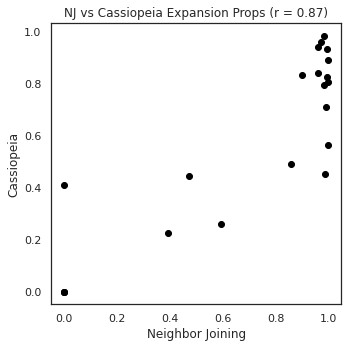

In [21]:
totalprop_nj = total_expansion_df_nj.groupby("Tumor").agg({"TotalProp": sum})
totalprop_cas = total_expansion_df_cas.groupby("Tumor").agg({"TotalProp": sum})

pearsonr = round(stats.pearsonr(totalprop_nj['TotalProp'], totalprop_cas.loc[totalprop_nj.index.values, 'TotalProp'])[0], 2)

sns.set(font_scale=1)
sns.set_style("white")
fig = plt.figure(figsize=(5,5))
plt.scatter(totalprop_nj, totalprop_cas.loc[totalprop_nj.index.values], color='black')
plt.title(f"NJ vs Cassiopeia Expansion Props (r = {pearsonr})")
plt.xlabel("Neighbor Joining")
plt.ylabel("Cassiopeia")
plt.tight_layout()

### Figures S2A-D

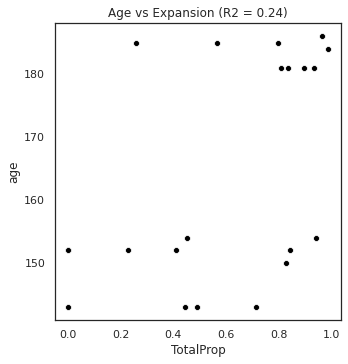

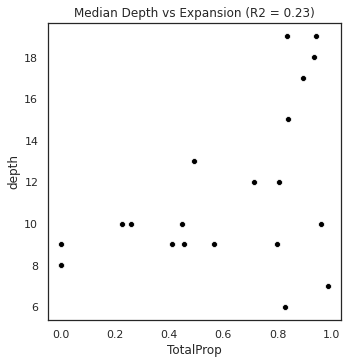

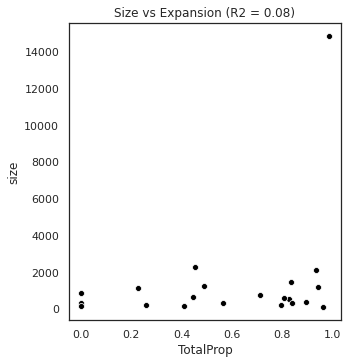

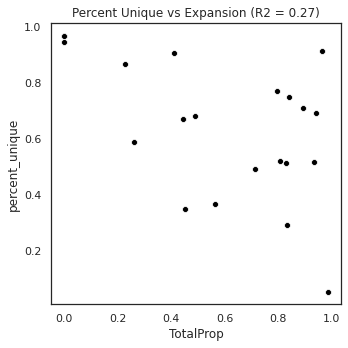

In [36]:
aging_day = trcr_master[['Tumor_combined', 'Aging_day']].drop_duplicates().set_index('Tumor_combined')['Aging_day'].to_dict()

total_expansion = total_expansion_df_cas.groupby("Tumor").agg({"TotalProp": sum})
total_expansion['age'] = total_expansion.apply(lambda x: aging_day[x.name], axis=1)
total_expansion['size'] = np.nan
total_expansion['depth'] = np.nan
total_expansion['percent_unique'] = np.nan


for tumor in total_expansion.index:
    
    tree_fp = f"{data_directory}/trees/{tumor}_tree.nwk"
    tree = ete3.Tree(tree_fp, 1)
    
    tree = solver_utilities.collapse_unifurcations(tree)
    
    total_expansion.loc[tumor, 'depth'] = np.median([tree.get_distance(l) for l in tree.get_leaves()])
    total_expansion.loc[tumor, 'size'] = len(tree.get_leaf_names())
    total_expansion.loc[tumor, 'percent_unique'] = tumor_clone_statistics.loc[tumor, 'PercentUnique']
    
    
sns.set(font_scale=1)
sns.set_style("white")

fig = plt.figure(figsize=(5,5))
r2 = round(stats.pearsonr(total_expansion['TotalProp'], total_expansion['age'])[0]**2, 2)
sns.scatterplot(x = 'TotalProp', y = 'age', data=total_expansion, color='black')
plt.tight_layout()
plt.title(f"Age vs Expansion (R2 = {r2})")
plt.show()

fig = plt.figure(figsize=(5,5))
r2 = round(stats.pearsonr(total_expansion['TotalProp'], total_expansion['depth'])[0]**2, 2)
sns.scatterplot(x = 'TotalProp', y = 'depth', data=total_expansion, color='black')
plt.tight_layout()
plt.title(f"Median Depth vs Expansion (R2 = {r2})")
plt.show()


fig = plt.figure(figsize=(5,5))
r2 = round(stats.pearsonr(total_expansion['TotalProp'], total_expansion['size'])[0]**2, 2)
sns.scatterplot(x = 'TotalProp', y = 'size', data=total_expansion, color='black')
plt.tight_layout()
plt.title(f"Size vs Expansion (R2 = {r2})")
plt.show()

fig = plt.figure(figsize=(5,5))
r2 = round(stats.pearsonr(total_expansion['TotalProp'], total_expansion['percent_unique'])[0]**2, 2)
sns.scatterplot(x = 'TotalProp', y = 'percent_unique', data=total_expansion, color='black')
plt.title(f"Percent Unique vs Expansion (R2 = {r2})")
plt.tight_layout()
plt.show()


## Figure 2B

In [39]:
total_expansion_df_cas['genotype'] = total_expansion_df_cas.apply(lambda x: x.Tumor.split("_")[1], axis=1)
prop_df = total_expansion_df_cas[['Tumor', 'TotalProp', 'genotype']].copy()
prop_df['expansion_num'] = 0
# prop_df = prop_df.set_index('Tumor').copy()

for n, g in prop_df.groupby('Tumor'):
    
    for j, ind in zip(range(g.shape[0]), g.index.values):
        prop_df.loc[ind, 'expansion_num'] += (j + 1)

nt = prop_df[prop_df['genotype'] == 'NT']

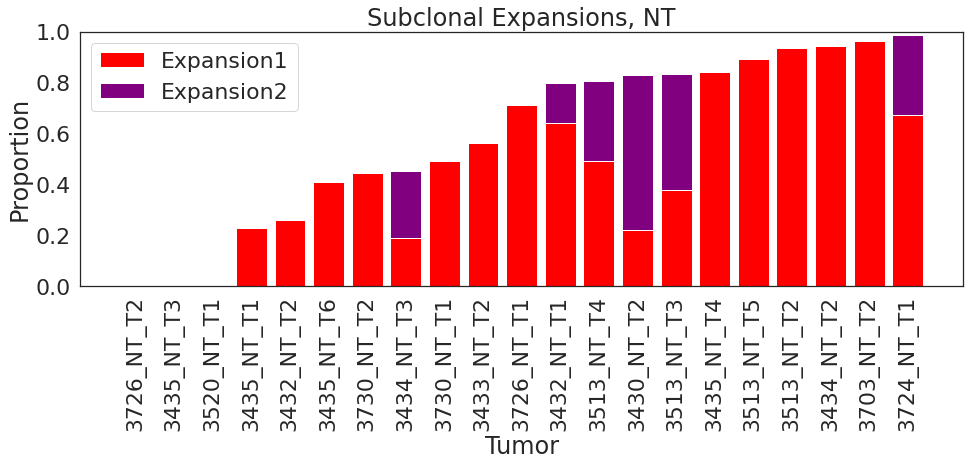

In [44]:
sns.set(font_scale=2)
sns.set_style("white")

for n, nt in prop_df.groupby('genotype'):

    nt['expansion_num'] = nt['expansion_num'].astype(int)
    max_num = nt['expansion_num'].max()
    
    nt['TotalPropSum'] = 0.0
    for tumor in nt["Tumor"].unique():
        nt.loc[nt['Tumor'] == tumor, 'TotalPropSum'] = nt.loc[nt['Tumor'] == tumor, 'TotalProp'].sum()

    nrs = []
    for tum in nt['Tumor'].unique():

        max_num_tum = nt.loc[nt['Tumor'] == tum, 'expansion_num'].max()
        for j in range(int(max_num - max_num_tum)):

            nr = pd.DataFrame([[tum, 0.0, n, j+max_num_tum+1]],
                              columns = ['Tumor', 'TotalProp','genotype', 'expansion_num'])
            nrs.append(nr)

    nt = pd.concat([nt] + nrs)
    nt = nt.sort_values(by='TotalPropSum')
    tumor_order = nt['Tumor'].unique()

    h = plt.figure(figsize = (14, 7))
    bottoms = np.array([0.0]*len(nt.Tumor.unique()))
    
    colors = ['red', 'purple']
    for exp in range(1, max_num+1):

        df = nt[nt['expansion_num'] == exp].set_index('Tumor')
        df = df.loc[tumor_order]
        plt.bar(df.index.values,
                df['TotalProp'].values,
                bottom = bottoms,
                label='Expansion' + str(exp),
                color=colors[exp-1]
               )
        bottoms += df['TotalProp'].to_numpy()

    plt.legend()
    plt.xticks(rotation=90)
    plt.ylim(0, 1)
    plt.xlabel('Tumor')
    plt.ylabel('Proportion')
    plt.title('Subclonal Expansions, ' + str(n))
    plt.tight_layout()
    plt.show()

### Figure 2E & 2H

In [58]:
cellcycle_ss = pd.DataFrame(sigscores[['REACTOME_CELL_CYCLE', 'CellCycle', 'G1/S', 'G2/M', 'FitnessSignature']], dtype=float)
cellcycle_ss['is_expanding'] = np.nan
cellcycle_ss['Tumor'] = np.nan
cellcycle_ss['fitness'] = np.nan

expanding_dist = []
nonexpanding_dist = []

for tumor in tqdm(tumor_list['Tumor'].values):
        
    if 'NT' not in tumor:
        continue
    
    if 'Fam' in tumor or 'Mets' in tumor or tumor in filtered or 'All' in tumor:
        continue
    
    tree = ete3.Tree(f"{data_directory}/{tumor}_tree.nwk", 1)
    fitness = pd.read_csv(f"{data_directory}/fitnesses/mean_fitness.{tumor}.txt", sep='\t', index_col = 0)

    node_iter = 0
    for n in tree.traverse():
        if not n.is_leaf():
            n.name = f'node-{node_iter}'
            node_iter += 1
    
    tree = solver_utilities.collapse_unifurcations(tree)
    tree, expansions = clonal_expansions.detect_expansion(tree, pval=0.01, min_depth=1, _first=False, min_clade_prop = 0.15)
    
    if expansions.shape[0]:
        cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, tree.get_leaf_names()), 'is_expanding'] = 'non_expanding'
    
    cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, tree.get_leaf_names()), 'is_expanding'] = 'non_expanding'
    for ind, exp in expansions.iterrows():
        
        leaves = (tree&ind).get_leaf_names()
        cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, leaves), 'is_expanding'] = 'rapid_expansion'
        
    ma, mi = np.max(fitness['mean_fitness']), np.min(fitness['mean_fitness'])
    fitness['mean_fitness'] = fitness['mean_fitness'].transform(lambda x: (x - mi) / (ma - mi))
    
    overlapping_cells = np.intersect1d(fitness.index, cellcycle_ss.index)
    cellcycle_ss.loc[overlapping_cells, 'fitness'] = fitness.loc[overlapping_cells, 'mean_fitness']
    cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, tree.get_leaf_names()), 'Tumor'] = tumor
    
cellcycle_ss = cellcycle_ss[~cellcycle_ss['is_expanding'].isna()]
cellcycle_ss['is_expanding'] = cellcycle_ss['is_expanding'].astype('category')

  0%|          | 0/88 [00:00<?, ?it/s]

In [59]:
ma, mi = np.max(cellcycle_ss['REACTOME_CELL_CYCLE']), np.min(cellcycle_ss['REACTOME_CELL_CYCLE'])

cellcycle_ss['REACTOME_CELL_CYCLE'] = cellcycle_ss['REACTOME_CELL_CYCLE'].transform(lambda x: (x - mi) / (ma - mi))

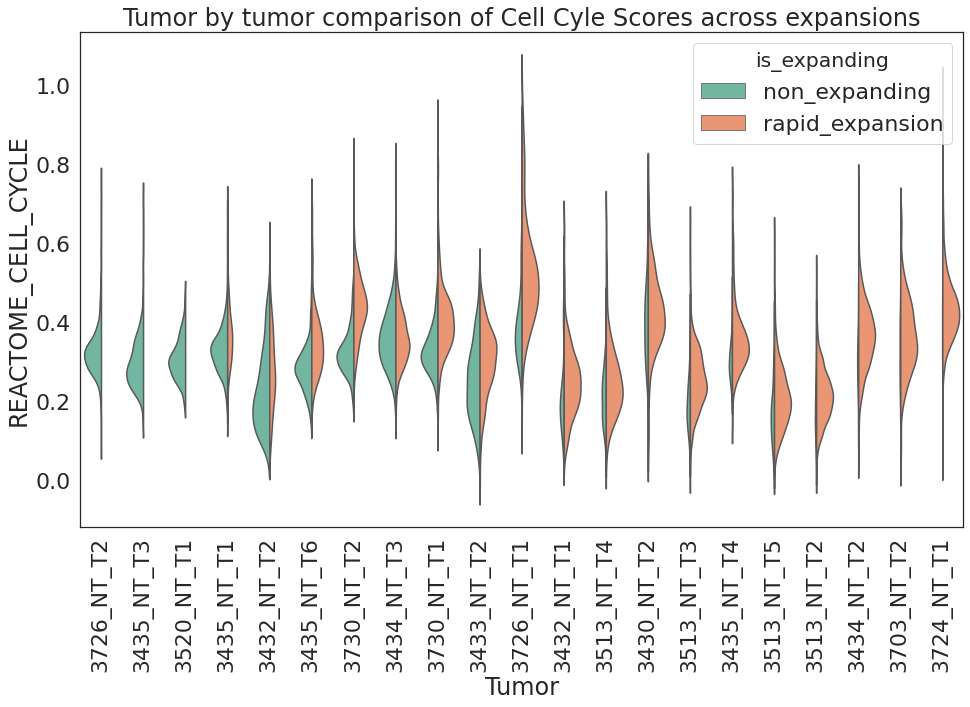

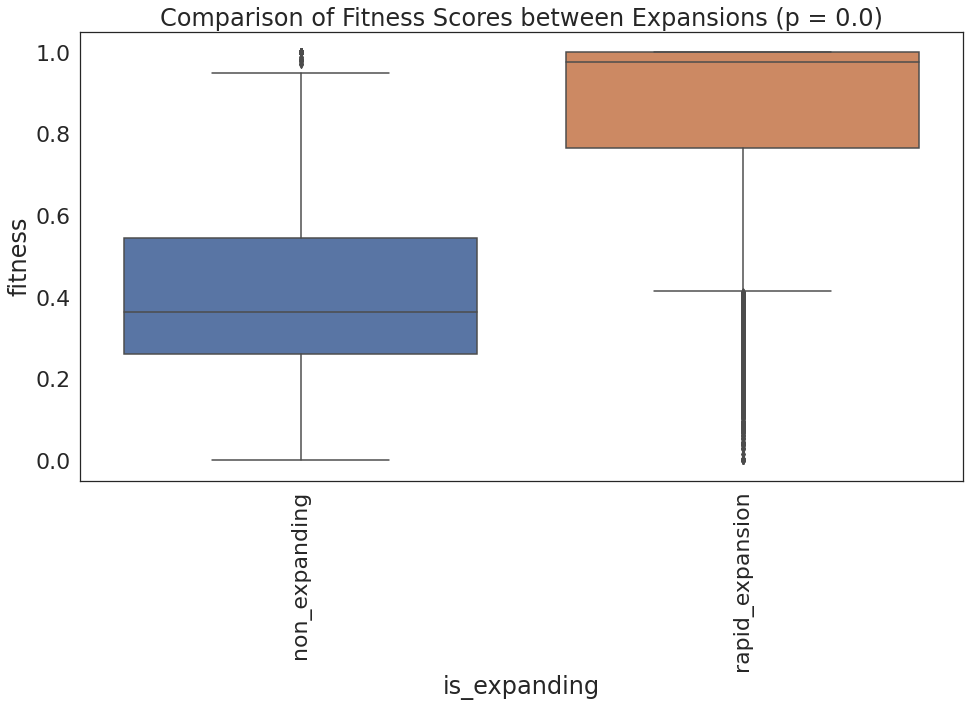

In [64]:
order = tumor_order

h = plt.figure(figsize=(14, 10))
sns.set(font_scale=2)
sns.set_style("white")
sns.violinplot(x = 'Tumor', y="REACTOME_CELL_CYCLE", hue="is_expanding",
                    data=cellcycle_ss, palette="Set2", split=True,
                    scale="count", inner=None, order=order)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Tumor by tumor comparison of Cell Cyle Scores across expansions")
plt.show()

wilcox = stats.ranksums(cellcycle_ss.loc[cellcycle_ss['is_expanding'] == 'rapid_expansion', 'REACTOME_CELL_CYCLE'].values,
                      cellcycle_ss.loc[cellcycle_ss['is_expanding'] == 'non_expanding', 'REACTOME_CELL_CYCLE'].values)

h = plt.figure(figsize=(14, 10))
sns.set(font_scale=2)
sns.set_style("white")
sns.boxplot(x = 'is_expanding', y="fitness",
                    data=cellcycle_ss)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title(f"Comparison of Fitness Scores between Expansions (p = {wilcox[1]})")
plt.show()

### Figure 2G

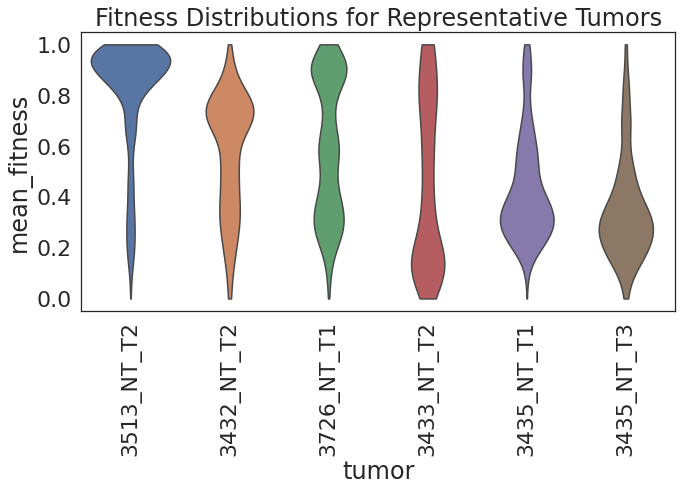

In [77]:
tumor_to_fitness = pd.DataFrame(columns = ['mean_fitness', 'tumor'])

target_tumors = ['3513_NT_T2', '3432_NT_T2', '3726_NT_T1', '3433_NT_T2', '3435_NT_T1', '3435_NT_T3']

for k, tumor in zip(range(len(target_tumors)), target_tumors):
    
    fitness_fp = f"{data_directory}/fitnesses/mean_fitness.{tumor}.txt"
    fitness_df = pd.read_csv(fitness_fp, sep='\t', index_col = 0)
    
    _mi, _ma = fitness_df['mean_fitness'].min(), fitness_df['mean_fitness'].max()
    fitness_df['mean_fitness'] = fitness_df['mean_fitness'].apply(lambda x: (x - _mi) / (_ma - _mi))
    
    fitness_df['tumor'] = tumor
    tumor_to_fitness = pd.concat([tumor_to_fitness, fitness_df])
    
h = plt.figure(figsize = (10, 7))
ax = plt.gca()
sns.violinplot(x = 'tumor', y='mean_fitness', data=tumor_to_fitness, ax=ax, cut=0, inner=None)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Fitness Distributions for Representative Tumors")
plt.show()

### Figure 2F

In [67]:
cellcycle_ss = pd.DataFrame(sigscores[['REACTOME_CELL_CYCLE', 'CellCycle', 'G1/S', 'G2/M', 'FitnessSignature']], dtype=float)
cellcycle_ss['is_expanding'] = np.nan
cellcycle_ss['Tumor'] = np.nan
cellcycle_ss['fitness'] = np.nan

expanding_dist = []
nonexpanding_dist = []

for tumor in tqdm(tumor2model.index):
        
    if 'NT' not in tumor:
        continue
    
    if 'Fam' in tumor or 'Mets' in tumor or tumor in filtered or 'All' in tumor:
        continue
    
    tree = ete3.Tree(f"{data_directory}/trees/neighbor_joining/{tumor}_tree_nj.processed.tree", 1)
    fitness = pd.read_csv(f"{data_directory}/fitnesses/mean_fitness.{tumor}.txt", sep='\t', index_col = 0)

    node_iter = 0
    for n in tree.traverse():
        if not n.is_leaf():
            n.name = f'node-{node_iter}'
            node_iter += 1
    
    tree = solver_utilities.collapse_unifurcations(tree)
    tree, expansions = clonal_expansions.detect_expansion(tree, pval=0.01, min_depth=1, _first=False, min_clade_prop = 0.15)
    
    if expansions.shape[0]:
        cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, tree.get_leaf_names()), 'is_expanding'] = 'non_expanding'
    
    cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, tree.get_leaf_names()), 'is_expanding'] = 'non_expanding'
    for ind, exp in expansions.iterrows():
        
        leaves = (tree&ind).get_leaf_names()
        cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, leaves), 'is_expanding'] = 'rapid_expansion'

    cellcycle_ss.loc[np.intersect1d(cellcycle_ss.index.values, tree.get_leaf_names()), 'Tumor'] = tumor
    
cellcycle_ss = cellcycle_ss[~cellcycle_ss['is_expanding'].isna()]
cellcycle_ss['is_expanding'] = cellcycle_ss['is_expanding'].astype('category')

  0%|          | 0/88 [00:00<?, ?it/s]

In [68]:
ma, mi = np.max(cellcycle_ss['REACTOME_CELL_CYCLE']), np.min(cellcycle_ss['REACTOME_CELL_CYCLE'])

cellcycle_ss['REACTOME_CELL_CYCLE'] = cellcycle_ss['REACTOME_CELL_CYCLE'].transform(lambda x: (x - mi) / (ma - mi))

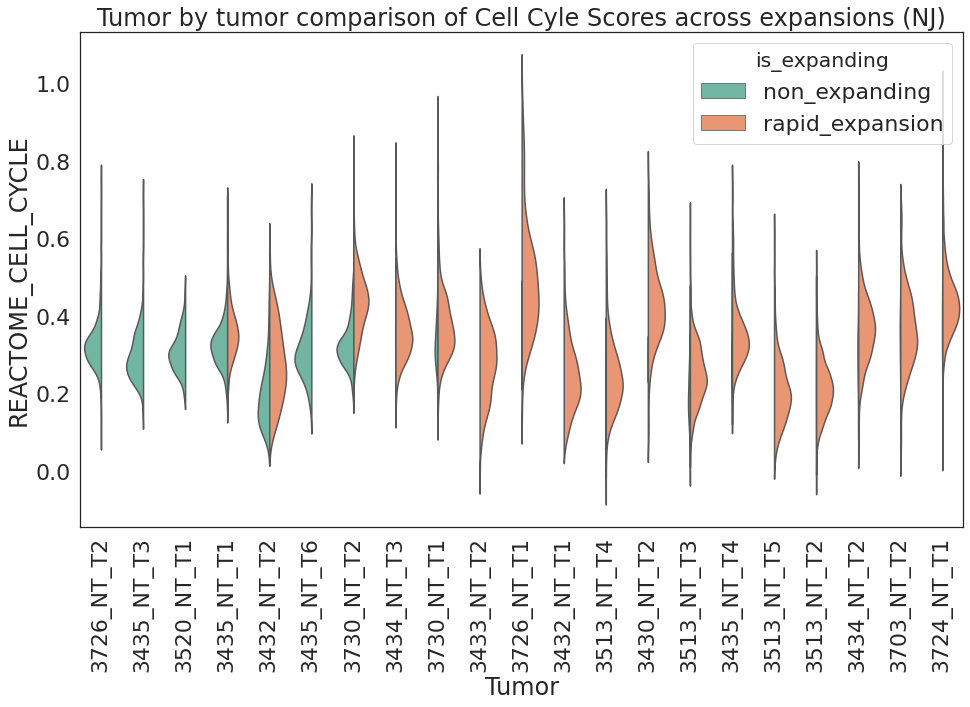

In [72]:
order = tumor_order

h = plt.figure(figsize=(14, 10))
sns.set(font_scale=2)
sns.set_style("white")
sns.violinplot(x = 'Tumor', y="REACTOME_CELL_CYCLE", hue="is_expanding",
                    data=cellcycle_ss, palette="Set2", split=True,
                    scale="count", inner=None, order=order)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("Tumor by tumor comparison of Cell Cyle Scores across expansions (NJ)")
plt.show()